In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import anndata
import os
from centroid_reference_scores import score_centroids, plot_binary_roc, get_perts
sns.set_style('whitegrid')

#### Get perturbation phenotypes

In [ ]:
!wget https://ars.els-cdn.com/content/image/1-s2.0-S0092867422005979-mmc3.xlsx
!wget https://ars.els-cdn.com/content/image/1-s2.0-S0092867422005979-mmc2.xlsx

In [5]:
phenotypes_df = pd.read_excel('1-s2.0-S0092867422005979-mmc3.xlsx', 3, index_col=0)
cin_k562_df = pd.read_excel('1-s2.0-S0092867422005979-mmc2.xlsx', 1, index_col=0)

#### Load predictions

In [6]:
outdir = '../results'
figdir = f'{outdir}/overleaf/figures'
datasets = ['ReplogleK562_gwps']
dataset_names = ['replogle_k562_gwps_2022']
dataset_labels = ['Replogle\n(K562)']

seeds = [1, 2, 3]
methods = ['cpa', 'gears', 'scgpt', 'scgpt_ft', 'nonctl-mean']

In [7]:
file = f'../data/{dataset_names[0]}/{dataset_names[0]}_{seeds[0]}.h5ad'
adata = anndata.read_h5ad(file)

In [8]:
# Calculate perturbation means
unique_conds = list(set(adata.obs['condition'].unique()) - set(['ctrl']))
post_gt_all_df = pd.DataFrame(columns=adata.var['gene_name'].values)
for condition in tqdm(unique_conds):
    adata_condition = adata[adata.obs['condition'] == condition]
    X_post = np.array(adata_condition.X.mean(axis=0))[0]  # adata_condition.X.mean(axis=0) is a np.matrix of
    post_gt_all_df.loc[len(post_gt_all_df)] = X_post
post_gt_all_df.index = unique_conds
post_gt_all_df.index = post_gt_all_df.index.str.split('+').str[0]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1813/1813 [02:35<00:00, 11.63it/s]


In [9]:
post_pred_dfs = []
post_gt_dfs = []
for dataset, dataset_name in zip(datasets, dataset_names):
    for seed in seeds:
        post_gt_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{methods[0]}_post-gt.csv', index_col=[0, 1])
        post_gt_df['seed'] = seed
        post_gt_dfs.append(post_gt_df)
        for method in tqdm(methods):
            p = f'{outdir}/{dataset}_{seed}_{method}_post-pred.csv'
            if not os.path.exists(p):
                print('Predictions not ready for method: ', method, 'dataset: ', dataset, 'seed: ', seed)
                continue
            post_pred_df = pd.read_csv(f'{outdir}/{dataset}_{seed}_{method}_post-pred.csv', index_col=[0, 1])
            post_pred_df['seed'] = seed
            post_pred_df['method'] = method
            post_pred_dfs.append(post_pred_df)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.79s/it]


In [10]:
post_gt_df = pd.concat(post_gt_dfs, axis=0)
post_gt_df = post_gt_df.reset_index()
post_gt_df['condition'] = post_gt_df['condition'].str.split('+').str[0]
post_gt_df = post_gt_df.set_index(['condition', 'seed'])
post_gt_df = post_gt_df.drop('n_train', axis=1)
post_pred_df = pd.concat(post_pred_dfs, axis=0)
post_pred_df = post_pred_df.reset_index()
post_pred_df['condition'] = post_pred_df['condition'].str.split('+').str[0]
post_pred_df = post_pred_df.set_index(['condition', 'method', 'seed'])
post_pred_df = post_pred_df[post_gt_df.columns]

#### Replogle phenotypes

In [14]:
phenotypes = {}
for i, row in phenotypes_df[['best_description', 'members']].iterrows():
    c = row['best_description']
    phenotypes[c] = row['members'].split(',')

In [16]:
seeds_ = [1, 2, 3]

# Ground truth
post_gt_df_seed = post_gt_df.reset_index()
post_gt_df_seed = post_gt_df_seed[post_gt_df_seed['seed'].isin(seeds_)]
post_gt_df_seed = post_gt_df_seed.drop('seed', axis=1).set_index('condition')
post_gt_df_seed = post_gt_df_seed.groupby(['condition']).mean()

# Predictions
post_pred_df_seed = post_pred_df.reset_index()
post_pred_df_seed = post_pred_df_seed[post_pred_df_seed['seed'].isin(seeds_)]
post_pred_df_seed = post_pred_df_seed.drop('seed', axis=1).set_index(['condition', 'method'])
post_pred_df_seed = post_pred_df_seed.groupby(['condition', 'method']).mean()
post_pred_df_seed

LINC01409    KLHL17      HES4     ISG15      SDF4  \
condition method                                                           
AAR2      cpa           0.069524  0.078041  0.148549  0.183875  0.496605   
          gears         0.077509  0.077440  0.144037  0.255898  0.458778   
          nonctl-mean   0.077623  0.064258  0.142994  0.212984  0.488672   
          scgpt         0.080140  0.065300  0.148600  0.236700  0.527000   
          scgpt_ft      0.075600  0.073240  0.126800  0.255400  0.519500   
...                          ...       ...       ...       ...       ...   
ZW10      cpa           0.082727  0.070386  0.148897  0.186189  0.491667   
          gears         0.105387  0.065610  0.146715  0.239703  0.497511   
          nonctl-mean   0.078142  0.063974  0.143876  0.213193  0.488766   
          scgpt         0.080350  0.065200  0.153450  0.228050  0.495250   
          scgpt_ft      0.082280  0.072430  0.141400  0.272650  0.513350   

                          ACAP3    INTS11     MXRA8     CCNL2    MRPL20  ...  \
condition method                                                         ...   
AAR2      cpa          0.056748  0.308812  0.114020  0.390491  1.037481  ...   
          gears        0.104337  0.296821  0.189294  0.376387  0.953462  ...   
          nonctl-mean  0.070134  0.296246  0.135772  0.388095  1.005126  ...   
          scgpt        0.071040  0.299800  0.148200  0.401600  1.027000  ...   
          scgpt_ft     0.073500  0.284400  0.152600  0.415000  1.013000  ...   
...                         ...       ...       ...       ...       ...  ...   
ZW10      cpa          0.054996  0.308535  0.109536  0.373549  1.024955  ...   
          gears        0.075406  0.276814  0.160182  0.412070  0.979399  ...   
          nonctl-mean  0.070211  0.296512  0.135484  0.388309  1.004387  ...   
          scgpt        0.072875  0.302100  0.147600  0.400100  1.004650  ...   
          scgpt_ft     0.075710  0.282950  0.163450  0.414550  0.952500  ...   

                        MT-ATP8   MT-ATP6    MT-CO3    MT-ND3   MT-ND4L  \
condition method                                                          
AAR2      cpa          0.750626  5.159684  5.681500  4.030646  1.725268   
          gears        0.673166  4.921972  5.511038  3.933837  1.642122   
          nonctl-mean  0.698377  5.007695  5.576916  4.012268  1.639934   
          scgpt        0.700700  5.215000  5.800000  4.130000  1.673000   
          scgpt_ft     0.694300  5.195000  5.848000  4.098000  1.695000   
...                         ...       ...       ...       ...       ...   
ZW10      cpa          0.747827  5.141247  5.661617  4.033896  1.718222   
          gears        0.688106  4.827679  5.477923  3.911058  1.604071   
          nonctl-mean  0.699393  5.007226  5.576645  4.012456  1.641199   
          scgpt        0.694800  5.172000  5.782500  4.141000  1.665500   
          scgpt_ft     0.626000  5.103500  5.804500  4.092500  1.532500   

                         MT-ND5    MT-ND6  BX004987.1  AL354822.1  AC240274.1  
condition method                                                               
AAR2      cpa          3.129834  1.740751    0.126658    0.109099    0.104804  
          gears        3.060099  1.615046    0.172965    0.144235    0.108366  
          nonctl-mean  3.078335  1.624646    0.125901    0.126403    0.099250  
          scgpt        3.154000  1.651000    0.129300    0.141100    0.101400  
          scgpt_ft     3.143000  1.571000    0.217300    0.223900    0.217000  
...                         ...       ...         ...         ...         ...  
ZW10      cpa          3.131743  1.683123    0.119545    0.113584    0.099296  
          gears        3.001168  1.606019    0.146485    0.156931    0.113850  
          nonctl-mean  3.080269  1.626094    0.126955    0.126402    0.098912  
          scgpt        3.163500  1.666000    0.131950    0.135400    0.096250  
          scgpt_ft     3.048500  1.419500    0.222950    

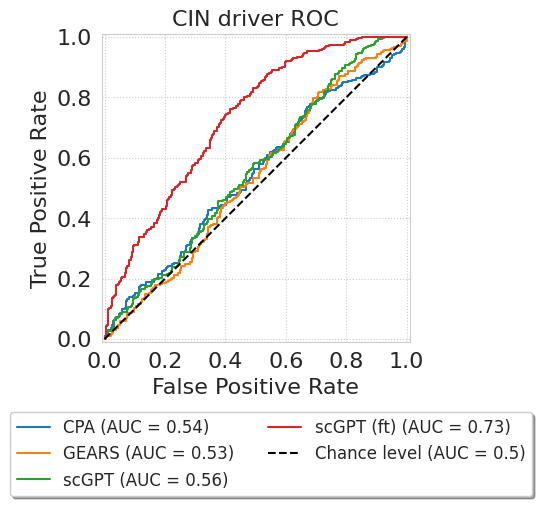

In [24]:
fontsize=16

# Chromosomal instabilities
cin_k562_df['gene_id'] = cin_k562_df.index.str.split('_').str[-1]
zscores_k562 = cin_k562_df[cin_k562_df['gene_id'].isin(adata.obs['gene_id'].unique())].groupby('gene_id')[['Z-scored CIN score']].mean()
df = adata.var[['gene_name']].copy()
df.loc['non-targeting'] = 'control'
zscores_k562['gene_name'] = df.loc[zscores_k562.index]
zscores_k562 = zscores_k562.set_index('gene_name')

# CIN and non CIN perturbations
m_pos = (zscores_k562 > 2).values.ravel()
m_neg = (zscores_k562 < 0).values.ravel()
cin_perts = zscores_k562.index[m_pos]
non_cin_perts = zscores_k562.index[m_neg]
test_perts = post_gt_df_seed.index
perts_dict = {'Chromosomal instability driver': np.intersect1d(test_perts, cin_perts),
              'Chromosomal instability non-driver': np.intersect1d(test_perts, non_cin_perts)}

labels, scores_dict = score_centroids(post_gt_df_seed, post_pred_df_seed, perts_dict, methods=methods)

fig = plt.figure(figsize=(4, 4))
plot_binary_roc(labels, scores_dict, methods[:-1])
plt.grid(linestyle='dotted')

ax = plt.gca()

ax.legend(loc='upper center', bbox_to_anchor=(0.55, -0.2), fancybox=True, shadow=True, ncol=2, fontsize=fontsize-4)

# Get the current legend
replace_dict = {'cpa': 'CPA',
                'gears': 'GEARS',
                'scgpt': 'scGPT',
                'scgpt_ft': 'scGPT (ft)'
               }
legend = ax.get_legend()
if legend:
    for text in legend.get_texts():
        label = text.get_text()
        for old, new in replace_dict.items():
            if old in label:
                text.set_text(label.replace(old, new))  # Replace text dynamically

plt.xlabel('False Positive Rate', fontsize=fontsize)
plt.ylabel('True Positive Rate', fontsize=fontsize)
plt.title('CIN driver ROC', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig(f'{figdir}/{dataset}_ROC_CINdriver.pdf', bbox_inches='tight');
plt.show()

In [33]:
post_pred_df_seed

LINC01409    KLHL17      HES4     ISG15      SDF4  \
condition method                                                           
AAR2      cpa           0.069524  0.078041  0.148549  0.183875  0.496605   
          gears         0.077509  0.077440  0.144037  0.255898  0.458778   
          nonctl-mean   0.077623  0.064258  0.142994  0.212984  0.488672   
          scgpt         0.080140  0.065300  0.148600  0.236700  0.527000   
          scgpt_ft      0.075600  0.073240  0.126800  0.255400  0.519500   
...                          ...       ...       ...       ...       ...   
ZW10      cpa           0.082727  0.070386  0.148897  0.186189  0.491667   
          gears         0.105387  0.065610  0.146715  0.239703  0.497511   
          nonctl-mean   0.078142  0.063974  0.143876  0.213193  0.488766   
          scgpt         0.080350  0.065200  0.153450  0.228050  0.495250   
          scgpt_ft      0.082280  0.072430  0.141400  0.272650  0.513350   

                          ACAP3    INTS11     MXRA8     CCNL2    MRPL20  ...  \
condition method                                                         ...   
AAR2      cpa          0.056748  0.308812  0.114020  0.390491  1.037481  ...   
          gears        0.104337  0.296821  0.189294  0.376387  0.953462  ...   
          nonctl-mean  0.070134  0.296246  0.135772  0.388095  1.005126  ...   
          scgpt        0.071040  0.299800  0.148200  0.401600  1.027000  ...   
          scgpt_ft     0.073500  0.284400  0.152600  0.415000  1.013000  ...   
...                         ...       ...       ...       ...       ...  ...   
ZW10      cpa          0.054996  0.308535  0.109536  0.373549  1.024955  ...   
          gears        0.075406  0.276814  0.160182  0.412070  0.979399  ...   
          nonctl-mean  0.070211  0.296512  0.135484  0.388309  1.004387  ...   
          scgpt        0.072875  0.302100  0.147600  0.400100  1.004650  ...   
          scgpt_ft     0.075710  0.282950  0.163450  0.414550  0.952500  ...   

                        MT-ATP8   MT-ATP6    MT-CO3    MT-ND3   MT-ND4L  \
condition method                                                          
AAR2      cpa          0.750626  5.159684  5.681500  4.030646  1.725268   
          gears        0.673166  4.921972  5.511038  3.933837  1.642122   
          nonctl-mean  0.698377  5.007695  5.576916  4.012268  1.639934   
          scgpt        0.700700  5.215000  5.800000  4.130000  1.673000   
          scgpt_ft     0.694300  5.195000  5.848000  4.098000  1.695000   
...                         ...       ...       ...       ...       ...   
ZW10      cpa          0.747827  5.141247  5.661617  4.033896  1.718222   
          gears        0.688106  4.827679  5.477923  3.911058  1.604071   
          nonctl-mean  0.699393  5.007226  5.576645  4.012456  1.641199   
          scgpt        0.694800  5.172000  5.782500  4.141000  1.665500   
          scgpt_ft     0.626000  5.103500  5.804500  4.092500  1.532500   

                         MT-ND5    MT-ND6  BX004987.1  AL354822.1  AC240274.1  
condition method                                                               
AAR2      cpa          3.129834  1.740751    0.126658    0.109099    0.104804  
          gears        3.060099  1.615046    0.172965    0.144235    0.108366  
          nonctl-mean  3.078335  1.624646    0.125901    0.126403    0.099250  
          scgpt        3.154000  1.651000    0.129300    0.141100    0.101400  
          scgpt_ft     3.143000  1.571000    0.217300    0.223900    0.217000  
...                         ...       ...         ...         ...         ...  
ZW10      cpa          3.131743  1.683123    0.119545    0.113584    0.099296  
          gears        3.001168  1.606019    0.146485    0.156931    0.113850  
          nonctl-mean  3.080269  1.626094    0.126955    0.126402    0.098912  
          scgpt        3.163500  1.666000    0.131950    0.135400    0.096250  
          scgpt_ft     3.048500  1.419500    0.222950    

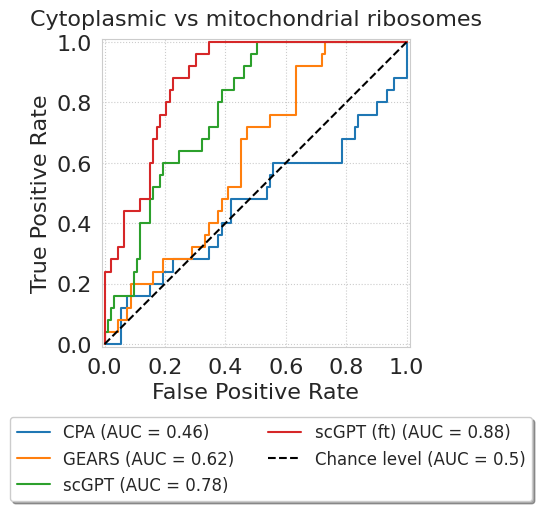

In [25]:
# This selection allows you to compare perturbations affecting cytoplasmic vs. mitochondrial ribosomes,
# which play distinct roles in cellular metabolism and stress responses. Cytoplasmic ribosomes handle
# bulk protein synthesis, while mitochondrial ribosomes are essential for oxidative phosphorylation.
class1_perts = get_perts(test_perts=post_gt_df_seed.index,
                              phenotypes=phenotypes, 
                              phenotype_names=['40S ribosomal subunit, cytoplasmic', '60S ribosomal subunit, cytoplasmic'])
class2_perts = get_perts(test_perts=post_gt_df_seed.index,
                                phenotypes=phenotypes, 
                            phenotype_names=[ '39S ribosomal subunit, mitochondrial', '28S ribosomal subunit, mitochondrial'])
perts_dict = {'Cytoplasmic': class1_perts, 'Mitochondrial': class2_perts}
assert len(np.intersect1d(class1_perts, class2_perts)) == 0

labels, scores_dict = score_centroids(post_gt_df_seed, post_pred_df_seed, perts_dict, methods=methods)

fig = plt.figure(figsize=(4, 4))
plot_binary_roc(labels, scores_dict, methods[:-1])
plt.grid(linestyle='dotted')

ax = plt.gca()
ax.legend(loc='upper center', bbox_to_anchor=(0.55, -0.2), fancybox=True, shadow=True, ncol=2, fontsize=fontsize-4)

# Get the current legend
replace_dict = {'cpa': 'CPA',
                'gears': 'GEARS',
                'scgpt': 'scGPT',
                'scgpt_ft': 'scGPT (ft)'
               }
legend = ax.get_legend()
if legend:
    for text in legend.get_texts():
        label = text.get_text()
        for old, new in replace_dict.items():
            if old in label:
                text.set_text(label.replace(old, new))  # Replace text dynamically

plt.xlabel('False Positive Rate', fontsize=fontsize)
plt.ylabel('True Positive Rate', fontsize=fontsize)
plt.title('Cytoplasmic vs mitochondrial ribosomes', fontsize=fontsize, pad=10)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig(f'{figdir}/{dataset}_ROC_CytoplasmicvsMitochondrial.pdf', bbox_inches='tight');
plt.show()

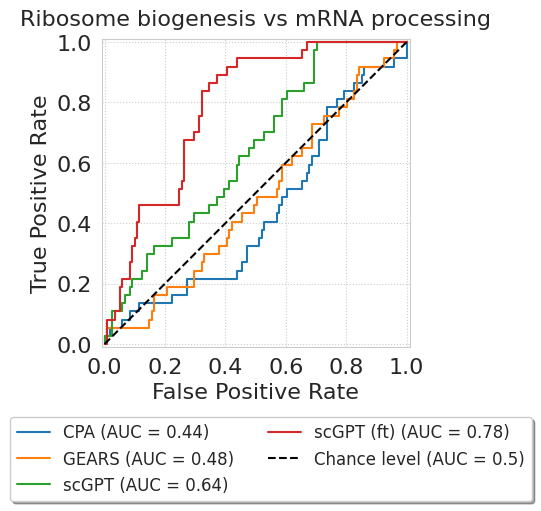

In [26]:
# Perturbations affecting RNA processing & turnover
class1_perts = get_perts(test_perts=post_gt_df_seed.index,
                              phenotypes=phenotypes, 
                              phenotype_names=['40S ribosomal subunit, cytoplasmic', '60S ribosomal subunit, cytoplasmic', '39S ribosomal subunit, mitochondrial', 'Pol I and rRNA biosynthesis'])
class2_perts = get_perts(test_perts=post_gt_df_seed.index,
                                phenotypes=phenotypes, 
                            phenotype_names=['spliceosome', 'exosome and mRNA turnover', 'nonsense-mediated decay', 'mRNA capping', 'mRNA polyadenylation'])
perts_dict = {'Ribosome biogenesis': class1_perts, 'mRNA processing': class2_perts}
assert len(np.intersect1d(class1_perts, class2_perts)) == 0

labels, scores_dict = score_centroids(post_gt_df_seed, post_pred_df_seed, perts_dict, methods)

fig = plt.figure(figsize=(4, 4))
plot_binary_roc(labels, scores_dict, methods[:-1])
plt.grid(linestyle='dotted')

ax = plt.gca()
ax.legend(loc='upper center', bbox_to_anchor=(0.55, -0.2), fancybox=True, shadow=True, ncol=2, fontsize=fontsize-4)

# Get the current legend
replace_dict = {'cpa': 'CPA',
                'gears': 'GEARS',
                'scgpt': 'scGPT',
                'scgpt_ft': 'scGPT (ft)'
               }
legend = ax.get_legend()
if legend:
    for text in legend.get_texts():
        label = text.get_text()
        for old, new in replace_dict.items():
            if old in label:
                text.set_text(label.replace(old, new))  # Replace text dynamically

plt.xlabel('False Positive Rate', fontsize=fontsize)
plt.ylabel('True Positive Rate', fontsize=fontsize)
plt.title('Ribosome biogenesis vs mRNA processing', fontsize=fontsize, pad=10)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig(f'{figdir}/{dataset}_ROC_Ribosome_biogenesis_vs_mRNA_processing.pdf', bbox_inches='tight');
plt.show()

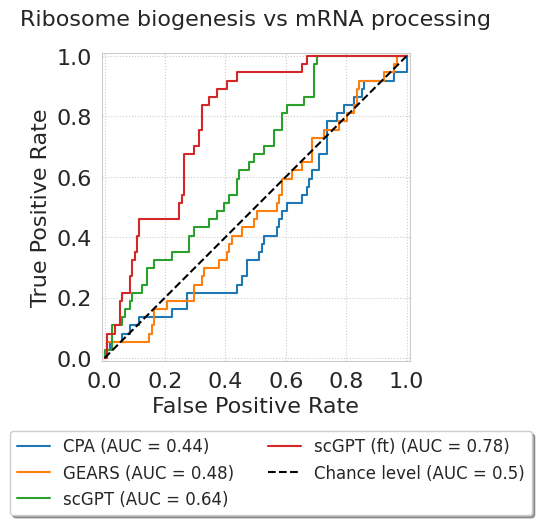

In [27]:
# Perturbations affecting RNA processing & turnover
class1_perts = get_perts(test_perts=post_gt_df_seed.index,
                              phenotypes=phenotypes, 
                              phenotype_names=['40S ribosomal subunit, cytoplasmic', '60S ribosomal subunit, cytoplasmic', '39S ribosomal subunit, mitochondrial', 'Pol I and rRNA biosynthesis'])
class2_perts = get_perts(test_perts=post_gt_df_seed.index,
                                phenotypes=phenotypes, 
                            phenotype_names=['spliceosome', 'exosome and mRNA turnover', 'nonsense-mediated decay', 'mRNA capping', 'mRNA polyadenylation'])
perts_dict = {'Ribosome biogenesis': class1_perts, 'mRNA processing': class2_perts}
assert len(np.intersect1d(class1_perts, class2_perts)) == 0

labels, scores_dict = score_centroids(post_gt_df_seed, post_pred_df_seed, perts_dict, methods)

fig = plt.figure(figsize=(4, 4))
plot_binary_roc(labels, scores_dict, methods[:-1])
plt.grid(linestyle='dotted')

ax = plt.gca()
ax.legend(loc='upper center', bbox_to_anchor=(0.55, -0.2), fancybox=True, shadow=True, ncol=2, fontsize=fontsize-4)

# Get the current legend
replace_dict = {'cpa': 'CPA',
                'gears': 'GEARS',
                'scgpt': 'scGPT',
                'scgpt_ft': 'scGPT (ft)'
               }
legend = ax.get_legend()
if legend:
    for text in legend.get_texts():
        label = text.get_text()
        for old, new in replace_dict.items():
            if old in label:
                text.set_text(label.replace(old, new))  # Replace text dynamically

plt.xlabel('False Positive Rate', fontsize=fontsize)
plt.ylabel('True Positive Rate', fontsize=fontsize)
plt.title('Ribosome biogenesis vs mRNA processing', fontsize=fontsize, pad=20)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig(f'{figdir}/{dataset}_ROC_Ribosome_biogenesis_vs_mRNA_processing.pdf', bbox_inches='tight');
plt.show()

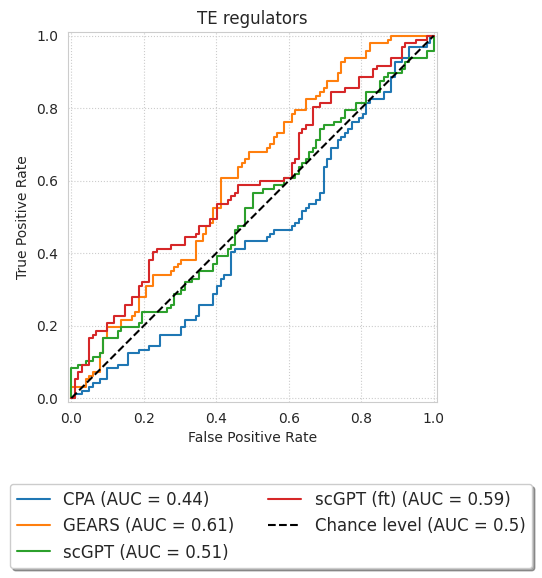

In [30]:
# TE RNA
cin_k562_df['gene_id'] = cin_k562_df.index.str.split('_').str[-1]
te_k562_df = cin_k562_df[cin_k562_df['gene_id'].isin(adata.obs['gene_id'].unique())].groupby('gene_id')[['Fraction of TE RNA']].mean()
df = adata.var[['gene_name']].copy()
df.loc['non-targeting'] = 'control'
te_k562_df['gene_name'] = df.loc[te_k562_df.index]
te_k562_df = te_k562_df.set_index('gene_name')

# Plot distribution and select thresholds
# plt.subplot(2, 1, 1)
# sns.histplot(te_k562_df['Fraction of TE RNA'])
low_t = np.percentile(te_k562_df['Fraction of TE RNA'], 10)
high_t = np.percentile(te_k562_df['Fraction of TE RNA'], 90)

# TE RNA inducing and non TE RNA inducing
m_pos = (te_k562_df > high_t).values.ravel()
m_neg = (te_k562_df < low_t).values.ravel()
te_perts = te_k562_df.index[m_pos]
non_te_perts = te_k562_df.index[m_neg]
test_perts = post_gt_df_seed.index
perts_dict = {'Transposable element regulator': np.intersect1d(test_perts, te_perts),
              'Transposable element non-regulator': np.intersect1d(test_perts, non_te_perts)}

labels, scores_dict = score_centroids(post_gt_df_seed, post_pred_df_seed, perts_dict, methods)
plot_binary_roc(labels, scores_dict, methods[:-1], title='TE regulators')
plt.grid(linestyle='dotted')

ax = plt.gca()
ax.legend(loc='upper center', bbox_to_anchor=(0.55, -0.2), fancybox=True, shadow=True, ncol=2, fontsize=fontsize-4)

# Get the current legend
replace_dict = {'cpa': 'CPA',
                'gears': 'GEARS',
                'scgpt': 'scGPT',
                'scgpt_ft': 'scGPT (ft)'
               }
legend = ax.get_legend()
if legend:
    for text in legend.get_texts():
        label = text.get_text()
        for old, new in replace_dict.items():
            if old in label:
                text.set_text(label.replace(old, new))  # Replace text dynamically

plt.show()

In [691]:
df = adata.to_df().T
df.index = adata.var.loc[df.index]['gene_name']
adata.obs['control_str'] = adata.obs['control'].astype(str)
res = gp.gsea(data=df.reset_index(), # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2023",
        cls=adata.obs['control_str'].values,
        permutation_num=500,
        permutation_type='phenotype',
        min_size=5,
        max_size=1000,
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)

2025-03-27 14:16:34,193 [WARNING] Found duplicated gene names, values averaged by gene names!
/home/vinas/miniconda3/envs/perturb_bench/lib/python3.10/site-packages/gseapy/base.py:230: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(level=0).mean()
/home/vinas/miniconda3/envs/perturb_bench/lib/python3.10/site-packages/gseapy/gsea.py:105: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_std = df.groupby(by=cls_dict, axis=1).std(numeric_only=True)


In [695]:
res.res2d[res.res2d['FDR q-val'] < 0.05].iloc[:50]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,rRNA Processing (GO:0006364),-0.753913,-2.840722,0.0,0.0,0.0,59/81,19.72%,NOLC1;RPL14;PRKDC;DKC1;LYAR;EBNA1BP2;RPS6;RPS1...
1,gsea,ncRNA Processing (GO:0034470),-0.726298,-2.764431,0.0,0.0,0.0,55/82,20.57%,NOLC1;POP7;RPL14;DKC1;LYAR;EBNA1BP2;RPS6;RPS17...
2,gsea,Ribosome Biogenesis (GO:0042254),-0.707464,-2.759062,0.0,0.0,0.0,81/124,20.03%,NPM1;RPS9;NOLC1;MRPS12;RPL14;DKC1;LYAR;EBNA1BP...
3,gsea,protein-RNA Complex Assembly (GO:0022618),-0.652344,-2.745796,0.0,0.0,0.0,53/109,15.88%,HSP90AB1;HSP90AA1;HNRNPC;EIF3B;RPSA;DHX9;SNRPG...
4,gsea,rRNA Metabolic Process (GO:0016072),-0.746502,-2.711329,0.0,0.0,0.0,49/68,19.35%,NOLC1;RPL14;DKC1;LYAR;EBNA1BP2;RPS6;RPS17;RPL7...
5,gsea,Regulation Of Translation (GO:0006417),-0.596234,-2.650421,0.0,0.0,0.0,45/120,13.70%,NPM1;NCL;GAPDH;YBX1;SERBP1;EIF3B;RPS3;NOLC1;PR...
6,gsea,Ribonucleoprotein Complex Biogenesis (GO:0022613),-0.707556,-2.640612,0.0,0.0,0.0,54/95,13.83%,NPM1;RPS9;MRPS12;RPL14;EBNA1BP2;NOP16;RPS6;RPS...
7,gsea,Ribosomal Small Subunit Biogenesis (GO:0042274),-0.705761,-2.62686,0.0,0.0,0.0,37/70,13.37%,NPM1;RPS9;RPSA;MRPS12;RPS6;RPS17;FBL;NOP14;HEA...
8,gsea,Gene Expression (GO:0010467),-0.655249,-2.579685,0.0,0.0,0.0,114/206,19.82%,HSPD1;HNRNPA2B1;RPS9;RPS2;RPS26;RPS3;HNRNPU;RP...
9,gsea,Ribosomal Large Subunit Biogenesis (GO:0042273),-0.766329,-2.560448,0.0,0.0,0.0,31/45,14.38%,NPM1;RPL14;RPL6;MDN1;EBNA1BP2;NOP16;LAS1L;RPL7...


In [703]:
res.res2d[res.res2d['Term'].str.contains('ifferentiation')].sort_values('FDR q-val').iloc[:50]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
345,gsea,T-helper Cell Differentiation (GO:0042093),-0.756094,-1.653432,0.0,0.080167,1.0,2/6,1.76%,HMGB1;MYB
402,gsea,Regulation Of Megakaryocyte Differentiation (G...,-0.660218,-1.613028,0.023715,0.102221,1.0,4/8,10.74%,PRMT1;MYB;HMGB2;EIF6
413,gsea,Negative Regulation Of Myeloid Cell Differenti...,-0.639764,-1.606627,0.030303,0.105307,1.0,3/10,5.67%,PRMT1;MYB;HSPA9
474,gsea,Negative Regulation Of Cell Differentiation (G...,-0.37015,-1.565412,0.012821,0.130785,1.0,27/71,28.91%,ANP32B;HNRNPU;MYB;CCDC85B;CALR;ACTB;PTBP1;SMAR...
681,gsea,Regulation Of Lymphocyte Differentiation (GO:0...,-0.603037,-1.44731,0.081301,0.228936,1.0,5/8,16.87%,PRKDC;PRELID1;XRCC6;METTL3;ZFP36L2
732,gsea,Regulation Of Stem Cell Differentiation (GO:20...,-0.42518,-1.418489,0.080972,0.25559,1.0,10/23,26.87%,HNRNPU;PRKDC;CHD4;MBD3;CHD3;METTL3;ZFP36L2;RBB...
757,gsea,Positive Regulation Of Erythrocyte Differentia...,-0.457273,-1.400396,0.089069,0.278438,1.0,5/20,19.98%,PRMT1;PRKDC;HMGB2;HSPA1A;STAT5B
193,gsea,Myotube Differentiation (GO:0014902),0.839587,1.805403,0.003922,0.287926,0.954,2/6,3.49%,PLD3;SORT1
804,gsea,Neural Crest Cell Differentiation (GO:0014033),-0.613212,-1.381703,0.087137,0.292911,1.0,2/7,3.09%,NOLC1;TCOF1
953,gsea,Regulation Of Hematopoietic Progenitor Cell Di...,-0.466055,-1.32689,0.146245,0.338007,1.0,3/12,16.08%,PRKDC;MYB;METTL3


In [1157]:
def calculate_pairwise_scores(dist_df, self_distances_df, methods):
    pairwise_scores = {}
    for method in methods:
        x_df = dist_df.xs(method, level=1).sort_index()
        y_df = self_distances_df.xs(method, level=1).sort_index()
        assert np.all(x_df.index == y_df.index)
        pairwise_scores[method] = ((x_df > y_df.values).sum(axis=1)) / (x_df.shape[-1] - 1)
    pairwise_scores_df = pd.DataFrame(pairwise_scores)
    return pairwise_scores_df

def plot_gene_acc_comparison(x_df, y_df, lead_genes, fontsize, annotate_genes=False):
    x = x_df
    y = y_df
    plt.scatter(x, y, s=2, color='lightgray')  
    if annotate_genes:
        texts = []
        for i in range(len(x)):
            t = x.index.get_level_values(0)[i]
            if t in lead_genes:
                plt.scatter(x.iloc[i], y.iloc[i], s=5, color='red')
                text = plt.text(x.iloc[i], y.iloc[i], t, ha='center', fontsize=fontsize)
                texts.append(text) 
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

In [729]:
duplicate_genes = [g for g, v in Counter(adata.var['gene_name']).items() if v > 1]
genes = [g for g in post_gt_all_df.columns if g not in duplicate_genes]
agg_post_pred_df = post_pred_df.reset_index().groupby(['condition', 'method'])[genes].mean()
agg_post_pred_df

In [881]:
# Distances
distances = cdist(agg_post_pred_df[genes], post_gt_all_df[genes], metric='euclidean')
# control_mean = np.array(adata[adata.obs['control'] == 1, adata.var['gene_name'].isin(genes)].X.mean(axis=0))[0]
# cosine_distances = cdist(agg_post_pred_df[genes] - control_mean, post_gt_all_df[genes] - control_mean, metric='cosine')
dist_df = pd.DataFrame(distances, index=agg_post_pred_df.index, columns=post_gt_all_df.index)

# Self distances
col_idxs = [np.argwhere(dist_df.columns == g)[0][0] for g in index]
self_distances = np.diag(dist_df.iloc[np.arange(len(dist_df)), col_idxs])
self_distances_df = pd.DataFrame(self_distances, index=dist_df.index)

# Calculate pairwise scores
pairwise_scores_df = calculate_pairwise_scores(dist_df, self_distances_df, methods)

In [1253]:
# Distances
distances = cdist(agg_post_pred_df[genes], post_gt_all_df[genes], metric='euclidean')
# control_mean = np.array(adata[adata.obs['control'] == 1, adata.var['gene_name'].isin(genes)].X.mean(axis=0))[0]
# cosine_distances = cdist(agg_post_pred_df[genes] - control_mean, post_gt_all_df[genes] - control_mean, metric='cosine')
dist_df = pd.DataFrame(distances, index=agg_post_pred_df.index, columns=post_gt_all_df.index)

# Self distances
col_idxs = [np.argwhere(dist_df.columns == g)[0][0] for g in index]
self_distances = np.diag(dist_df.iloc[np.arange(len(dist_df)), col_idxs])
self_distances_df = pd.DataFrame(self_distances, index=dist_df.index)

# Calculate pairwise scores
pairwise_scores_df = calculate_pairwise_scores(dist_df, self_distances_df, methods)

In [1192]:
top_gs_scgptft

condition
RPL26     0.922737
RPL24     0.911148
RPL6      0.879139
RPS12     0.865342
RPL19     0.859272
            ...   
EIF1AD   -0.368102
CNDP2    -0.379139
CCNG1    -0.398455
USP42    -0.402870
ZNF561   -0.409492
Name: sample1, Length: 1043, dtype: float64

In [945]:
top_gs_scgptft = (pairwise_scores_df['scgpt_ft'] - pairwise_scores_df['nonctl-mean']).sort_values(ascending=False)
res_scgptft = gp.prerank(rnk=top_gs_scgptft, # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2023",
        outdir=None,
        threads= 16)
res_scgptft.res2d[res_scgptft.res2d['FDR q-val'] < 0.05]

2025-03-28 09:14:19,740 [WARNING] Duplicated values found in preranked stats: 15.15% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Cytoplasmic Translation (GO:0002181),0.880073,2.250967,0.0,0.0,0.0,35/43,12.85%,RPL26;RPL24;RPL6;RPL19;RPL34;RPL23A;RPS2;RPL38...
1,prerank,Positive Regulation Of DNA Repair (GO:0045739),-0.730003,-2.20146,0.0,0.006119,0.002,12/15,21.96%,DPF2;UBE2N;TFPT;INO80D;DHX9;WRAP53;ARID2;UCHL5...
2,prerank,Regulation Of Multicellular Organismal Develop...,-0.67414,-2.147518,0.0,0.009178,0.006,11/18,21.48%,MYSM1;TFPT;INO80D;ING5;BAG6;UCHL5;MBIP;MCRS1;N...
3,prerank,Peptide Biosynthetic Process (GO:0043043),0.804109,2.112165,0.0,0.0,0.0,36/62,10.55%,RPL26;RPL24;RPL6;RPL19;RPL34;RPL23A;RPS2;RPL38...
4,prerank,Macromolecule Biosynthetic Process (GO:0009059),0.790583,2.093566,0.0,0.0,0.0,36/68,10.55%,RPL26;RPL24;RPL6;RPL19;RPL34;RPL23A;RPS2;RPL38...
5,prerank,Regulation Of DNA Repair (GO:0006282),-0.546731,-2.000865,0.0,0.025495,0.023,16/32,21.96%,DPF2;UBE2N;TFPT;ING3;INO80D;DHX9;WRAP53;ARID2;...
6,prerank,Ribonucleoprotein Complex Biogenesis (GO:0022613),0.764449,1.989423,0.0,0.0,0.0,25/55,12.56%,RPL26;RPL38;RPS23;RPS7;NOP16;RPS27;NIP7;RPS9;U...
7,prerank,Translation (GO:0006412),0.735099,1.978805,0.0,0.0,0.0,45/88,16.11%,RPL26;RPL24;RPL6;RPL19;RPL34;RPL23A;RPS2;RPL38...
8,prerank,Regulation Of DNA Replication (GO:0006275),-0.63313,-1.955793,0.0,0.026769,0.033,12/17,20.71%,PPP2R1A;ATAD5;TFPT;INO80D;DHX9;ING5;PPP2CA;UCH...
9,prerank,Regulation Of DNA Metabolic Process (GO:0051052),-0.510081,-1.944284,0.0,0.024475,0.038,16/29,21.96%,PPP2R1A;UBE2N;TFPT;INO80D;ING5;PPP2CA;USP22;UC...


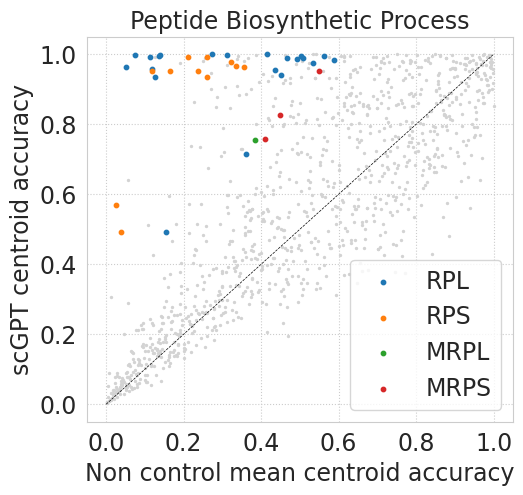

In [1186]:
fontsize=17
term = 'Peptide Biosynthetic Process (GO:0043043)'
lead_genes = res_scgptft.res2d.set_index('Term').loc[term]['Lead_genes'].split(';')
# plt.xlim((-0.19, 1.19))
# plt.ylim((0, 1.19))
plt.figure(figsize=(5.5, 5))
plot_gene_acc_comparison(pairwise_scores_df['nonctl-mean'],
                         pairwise_scores_df['scgpt_ft'],
                         lead_genes,
                         fontsize=fontsize-7,
                         annotate_genes=term != 'Peptide Biosynthetic Process (GO:0043043)')
x_df = pairwise_scores_df['nonctl-mean']
y_df = pairwise_scores_df['scgpt_ft']
gene_cats = ['RPL', 'RPS', 'MRPL', 'MRPS']
missing_lead_genes = np.intersect1d(lead_genes, x_df.index.get_level_values(0))
for cat in gene_cats:
    mask = y_df.index.str.startswith(cat)
    mask = np.logical_and(mask, [g in lead_genes for g in x_df.index])
    seen_lead_genes = x_df.loc[mask]
    missing_lead_genes = np.setdiff1d(missing_lead_genes, seen_lead_genes.index)
    plt.scatter(x_df.loc[mask],
                y_df.loc[mask],
                s=10, label=cat)
texts = []
for g in missing_lead_genes:
    i = np.argwhere(x_df.index.get_level_values(0) == g).ravel()
    plt.scatter(x_df.iloc[i], y_df.iloc[i], s=5, color='red')
    text = plt.text(x_df.iloc[i], y_df.iloc[i], g, ha='center', fontsize=fontsize-7)
    texts.append(text)
plt.legend(fontsize=fontsize)
plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', lw=0.5)  # Line from (0,0) to (1,1)
plt.grid(linestyle='dotted')
plt.xlabel('Non control mean centroid accuracy', fontsize=fontsize)
plt.ylabel('scGPT centroid accuracy', fontsize=fontsize);
plt.title(term.split('(')[0][:-1], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize);
plt.savefig(f'{figdir}/{dataset}_nonctlmean_vs_scgptft_centroid_accuracy_peptide_biosynthetic.pdf', bbox_inches='tight');
plt.show()

15
4
3
0


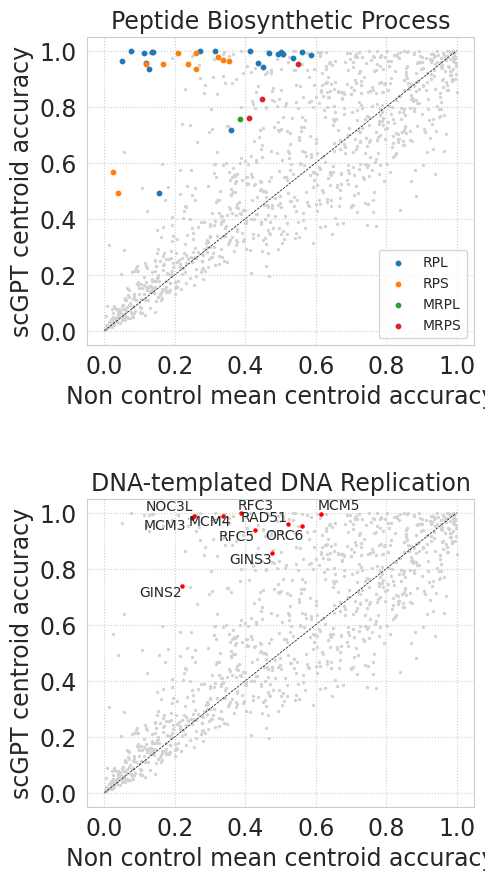

In [1178]:
fontsize=17
terms = ['Peptide Biosynthetic Process (GO:0043043)', 'DNA-templated DNA Replication (GO:0006261)']

plt.figure(figsize=(5, 5*len(terms)))
for i, term in enumerate(terms):
    plt.subplot(len(terms), 1, i+1)
    lead_genes = res_scgptft.res2d.set_index('Term').loc[term]['Lead_genes'].split(';')
    # plt.xlim((-0.19, 1.19))
    # plt.ylim((0, 1.19))
    plot_gene_acc_comparison(pairwise_scores_df['nonctl-mean'],
                             pairwise_scores_df['scgpt_ft'],
                             lead_genes,
                             fontsize=fontsize-7,
                             annotate_genes=term != 'Peptide Biosynthetic Process (GO:0043043)')
    if term == 'Peptide Biosynthetic Process (GO:0043043)':
        x_df = pairwise_scores_df['nonctl-mean']
        y_df = pairwise_scores_df['scgpt_ft']
        gene_cats = ['RPL', 'RPS', 'MRPL', 'MRPS']
        missing_lead_genes = np.intersect1d(lead_genes, x_df.index.get_level_values(0))
        for cat in gene_cats:
            mask = y_df.index.str.startswith(cat)
            mask = np.logical_and(mask, [g in lead_genes for g in x_df.index])
            seen_lead_genes = x_df.loc[mask]
            missing_lead_genes = np.setdiff1d(missing_lead_genes, seen_lead_genes.index)
            print(len(missing_lead_genes))
            plt.scatter(x_df.loc[mask],
                        y_df.loc[mask],
                        s=10, label=cat)
        texts = []
        for g in missing_lead_genes:
            i = np.argwhere(x_df.index.get_level_values(0) == g).ravel()
            plt.scatter(x_df.iloc[i], y_df.iloc[i], s=5, color='red')
            text = plt.text(x_df.iloc[i], y_df.iloc[i], g, ha='center', fontsize=fontsize-7)
            texts.append(text)
        plt.legend()
                
    plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', lw=0.5)  # Line from (0,0) to (1,1)
    plt.grid(linestyle='dotted')
    plt.xlabel('Non control mean centroid accuracy', fontsize=fontsize)
    plt.ylabel('scGPT centroid accuracy', fontsize=fontsize);
    plt.title(term.split('(')[0][:-1], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize);
plt.subplots_adjust(hspace=0.5)
# plt.tight_layout()
plt.savefig(f'{figdir}/{dataset}_nonctlmean_vs_scgptft_centroid_accuracy_selectedterms.pdf', bbox_inches='tight');
plt.show()

In [1255]:
lead_genes

['RPL26',
 'RPL24',
 'RPL6',
 'RPL19',
 'RPL34',
 'RPL23A',
 'RPS2',
 'RPL38',
 'RPS23',
 'RPS7',
 'RPSA',
 'RPL21',
 'RPS27',
 'RPL8',
 'RPS21',
 'RPS9',
 'RPS14',
 'RPS3A',
 'RPL4',
 'RPS18',
 'RPL9',
 'RPL28',
 'RPL15',
 'RPL37',
 'RPL12',
 'RPL32',
 'RPS24',
 'RPLP0',
 'RPL13',
 'MRPS33',
 'RPL11',
 'MRPS18A',
 'MRPL27',
 'MRPS24',
 'RPL29',
 'MRPS21',
 'MRPL17',
 'RPL31',
 'MRPL2',
 'MRPL38',
 'RPS5',
 'MRPS2',
 'PABPC4',
 'MRPL22',
 'MRPS15']

In [1293]:
text.get_text()

'RPSA'

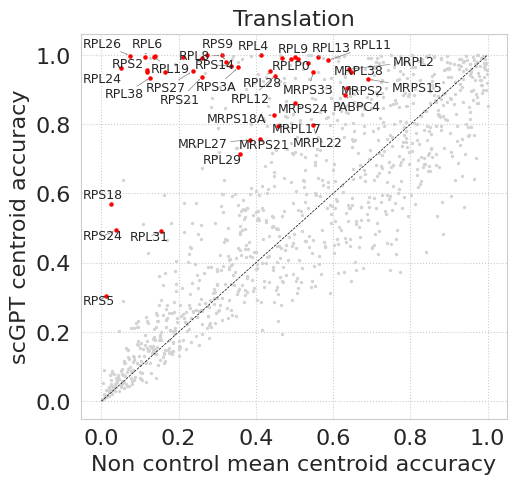

In [1312]:
term = 'Translation (GO:0006412)'
plt.figure(figsize=(5.5, 5))
lead_genes = res_scgptft.res2d.set_index('Term').loc[term]['Lead_genes'].split(';')
plot_gene_acc_comparison(pairwise_scores_df['nonctl-mean'],
                         pairwise_scores_df['scgpt_ft'],
                         lead_genes,
                         fontsize=fontsize-6,
                         annotate_genes=False)
texts = []
exclude_annotations = ['RPS23', 'RPL23A', 'RPL34', 'RPSA', 'RPL21', 'RPL15', 'RPL32', 'RPL37', 'RPS7']
x = pairwise_scores_df['nonctl-mean']
for i in range(len(x)):
    t = x.index.get_level_values(0)[i]
    if t in lead_genes:
        plt.scatter(x.iloc[i], y.iloc[i], s=5, color='red')
        if t not in exclude_annotations:
            text = plt.text(x.iloc[i], y.iloc[i], t, ha='center', fontsize=fontsize-7)
            texts.append(text) 
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', lw=0.5)  # Line from (0,0) to (1,1)
plt.grid(linestyle='dotted')
plt.xlabel('Non control mean centroid accuracy', fontsize=fontsize)
plt.ylabel('scGPT centroid accuracy', fontsize=fontsize);
plt.title(term.split('(')[0][:-1], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize);
plt.savefig(f'{figdir}/{dataset}_scgptft_centroid_accuracy_translation.pdf', bbox_inches='tight');

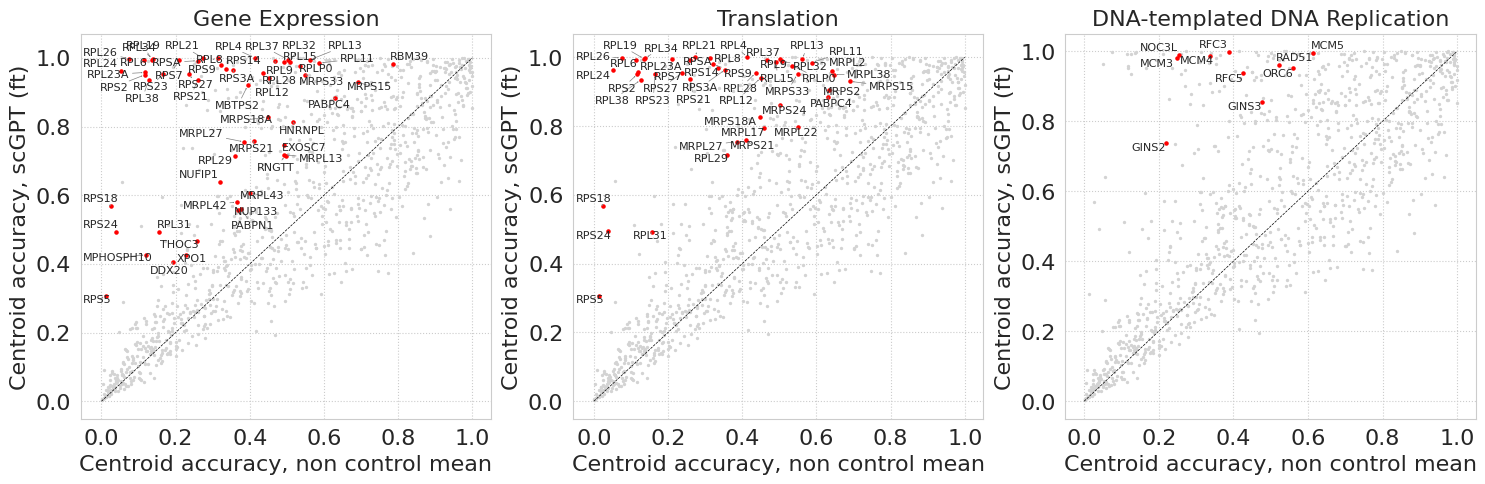

In [1314]:
fontsize=16
terms = ['Gene Expression (GO:0010467)', 'Translation (GO:0006412)', 'DNA-templated DNA Replication (GO:0006261)']

plt.figure(figsize=(6*len(terms), 5))
for i, term in enumerate(terms):
    plt.subplot(1, len(terms), i+1)
    lead_genes = res_scgptft.res2d.set_index('Term').loc[term]['Lead_genes'].split(';')
    plot_gene_acc_comparison(pairwise_scores_df['nonctl-mean'],
                             pairwise_scores_df['scgpt_ft'],
                             lead_genes,
                             fontsize=fontsize-8,
                             annotate_genes=True)
    plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', lw=0.5)  # Line from (0,0) to (1,1)
    plt.grid(linestyle='dotted')
    plt.xlabel('Centroid accuracy, non control mean', fontsize=fontsize)
    plt.ylabel('Centroid accuracy, scGPT (ft)', fontsize=fontsize);
    plt.title(term.split('(')[0][:-1], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize);
plt.savefig(f'{figdir}/{dataset}_scgptft_centroid_accuracy_expression_translation_DNArepl.pdf', bbox_inches='tight');

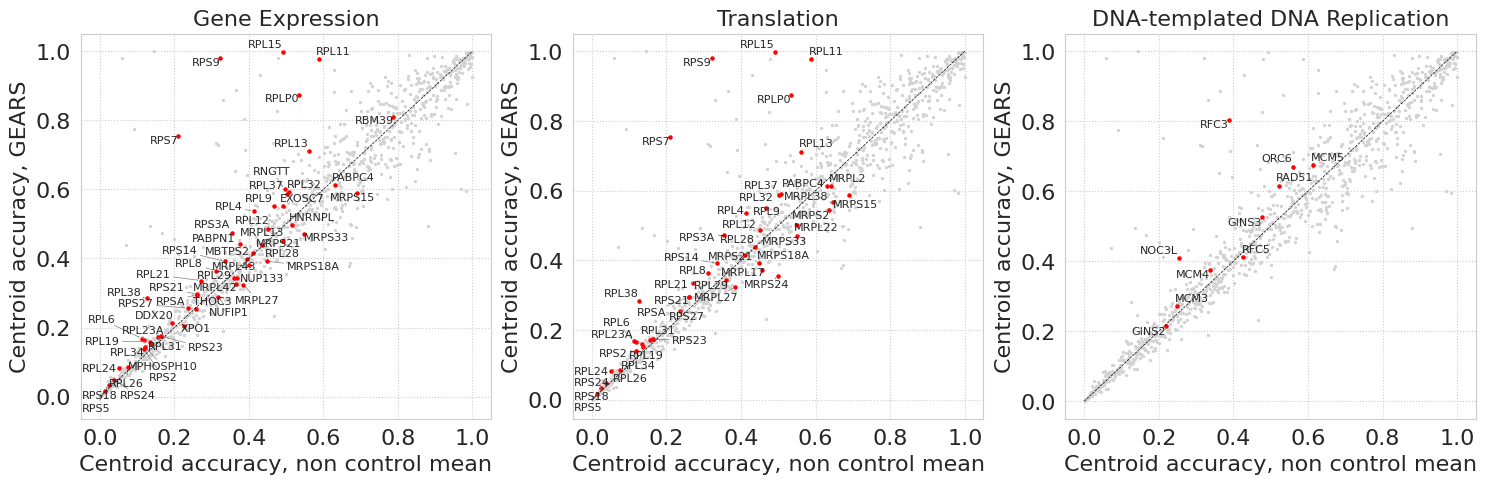

In [1316]:
fontsize=16
# terms = ['Gene Expression (GO:0010467)', 'Translation (GO:0006412)']
terms = ['Gene Expression (GO:0010467)', 'Translation (GO:0006412)', 'DNA-templated DNA Replication (GO:0006261)']

plt.figure(figsize=(6*len(terms), 5))
for i, term in enumerate(terms):
    plt.subplot(1, len(terms), i+1)
    lead_genes = res_scgptft.res2d.set_index('Term').loc[term]['Lead_genes'].split(';')
    plot_gene_acc_comparison(pairwise_scores_df['nonctl-mean'],
                             pairwise_scores_df['gears'],
                             lead_genes,
                             fontsize=fontsize-8,
                             annotate_genes=True)
    plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', lw=0.5)  # Line from (0,0) to (1,1)
    plt.grid(linestyle='dotted')
    plt.xlabel('Centroid accuracy, non control mean', fontsize=fontsize)
    plt.ylabel('Centroid accuracy, GEARS', fontsize=fontsize);
    plt.title(term.split('(')[0][:-1], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize);
plt.savefig(f'{figdir}/{dataset}_gears_centroid_accuracy_expression_translation_DNArepl.pdf', bbox_inches='tight');

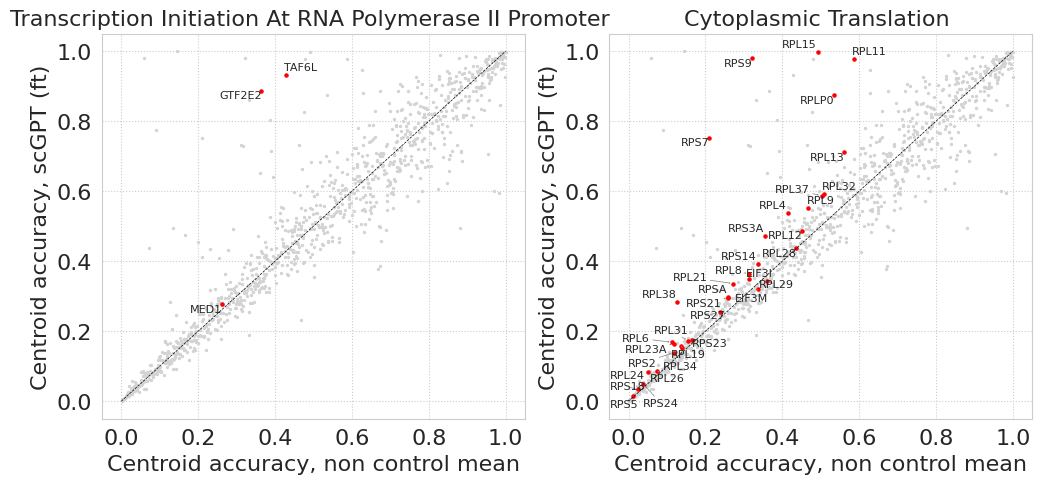

In [1275]:
fontsize=16
terms = res_gears.res2d.iloc[[2, 3]]['Term'].values # ['Gene Expression (GO:0010467)', 'Translation (GO:0006412)']

plt.figure(figsize=(6*len(terms), 5))
for i, term in enumerate(terms):
    plt.subplot(1, len(terms), i+1)
    lead_genes = res_scgptft.res2d.set_index('Term').loc[term]['Lead_genes'].split(';')
    plot_gene_acc_comparison(pairwise_scores_df['nonctl-mean'],
                             pairwise_scores_df['gears'],
                             lead_genes,
                             fontsize=fontsize-8,
                             annotate_genes=True)
    plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', lw=0.5)  # Line from (0,0) to (1,1)
    plt.grid(linestyle='dotted')
    plt.xlabel('Centroid accuracy, non control mean', fontsize=fontsize)
    plt.ylabel('Centroid accuracy, scGPT (ft)', fontsize=fontsize);
    plt.title(term.split('(')[0], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize);
plt.savefig(f'{figdir}/{dataset}_gears_centroid_accuracy_topgearspathways.pdf', bbox_inches='tight');

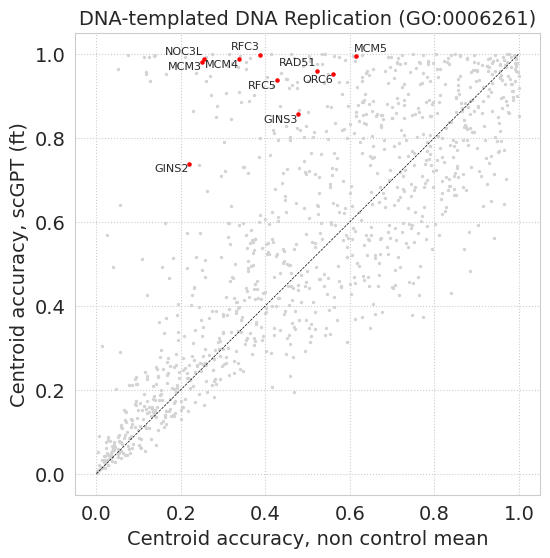

In [1048]:
fontsize=14
term = 'DNA-templated DNA Replication (GO:0006261)' #  'Peptide Biosynthetic Process (GO:0043043)'  # 'Positive Regulation Of DNA Repair (GO:0045739)'
lead_genes = res_scgptft.res2d.set_index('Term').loc[term]['Lead_genes'].split(';')

plt.figure(figsize=(6, 6))
plot_gene_acc_comparison(pairwise_scores_df['nonctl-mean'],
                         pairwise_scores_df['scgpt_ft'],
                         lead_genes,
                         fontsize=fontsize-6)
plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', lw=0.5)  # Line from (0,0) to (1,1)
plt.grid(linestyle='dotted')
plt.xlabel('Centroid accuracy, non control mean', fontsize=fontsize)
plt.ylabel('Centroid accuracy, scGPT (ft)', fontsize=fontsize);
plt.title(term, fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize);

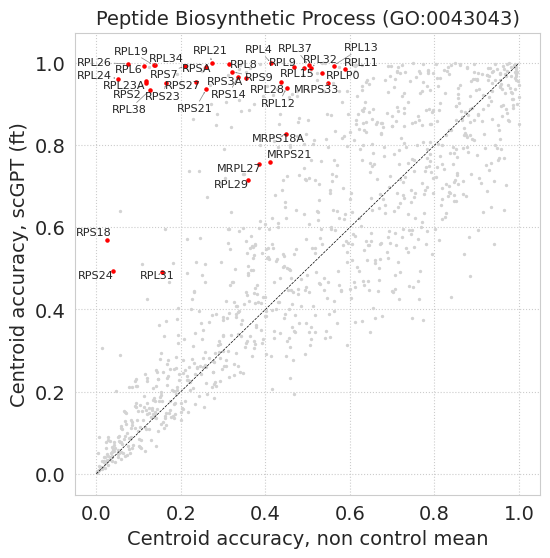

In [1033]:
fontsize=14
term = 'Peptide Biosynthetic Process (GO:0043043)'  # 'Positive Regulation Of DNA Repair (GO:0045739)'
lead_genes = res_scgptft.res2d.set_index('Term').loc[term]['Lead_genes'].split(';')

plt.figure(figsize=(6, 6))
plot_gene_acc_comparison(pairwise_scores_df['nonctl-mean'],
                         pairwise_scores_df['scgpt_ft'],
                         lead_genes,
                         fontsize=fontsize-6)
plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', lw=0.5)  # Line from (0,0) to (1,1)
plt.grid(linestyle='dotted')
plt.xlabel('Centroid accuracy, non control mean', fontsize=fontsize)
plt.ylabel('Centroid accuracy, scGPT (ft)', fontsize=fontsize);
plt.title(term, fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize);

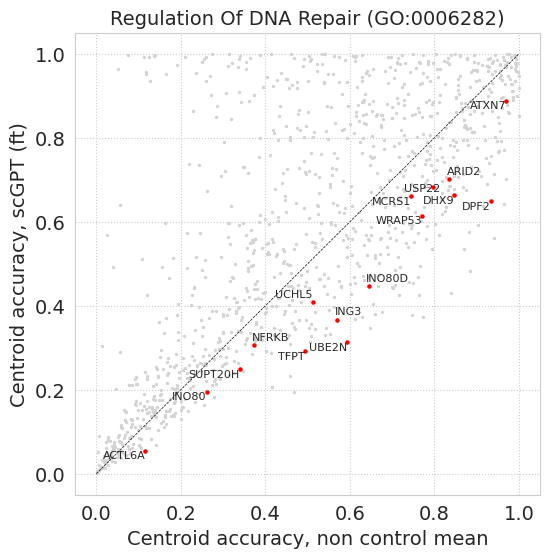

In [1035]:
fontsize=14
term = 'Regulation Of DNA Repair (GO:0006282)' # 'Positive Regulation Of DNA Repair (GO:0045739)'
lead_genes = res_scgptft.res2d.set_index('Term').loc[term]['Lead_genes'].split(';')

plt.figure(figsize=(6, 6))
plot_gene_acc_comparison(pairwise_scores_df['nonctl-mean'],
                         pairwise_scores_df['scgpt_ft'],
                         lead_genes,
                         fontsize=fontsize-6)
plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', lw=0.5)  # Line from (0,0) to (1,1)
plt.grid(linestyle='dotted')
plt.xlabel('Centroid accuracy, non control mean', fontsize=fontsize)
plt.ylabel('Centroid accuracy, scGPT (ft)', fontsize=fontsize);
plt.title(term, fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize);

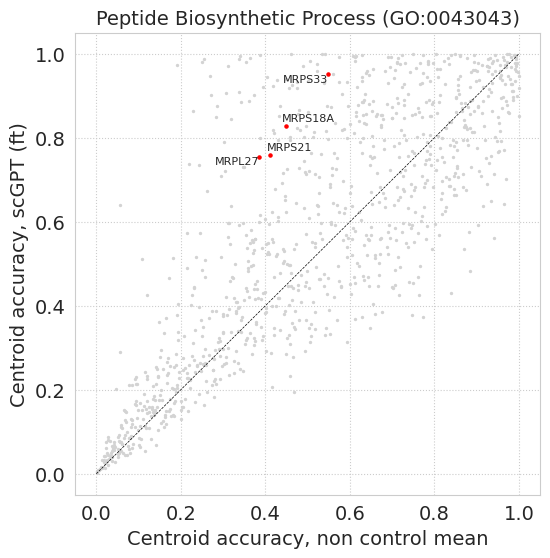

In [1047]:
pairwise_scores_df_ = pairwise_scores_df[~pairwise_scores_df.index.str.startswith('RP')]
fontsize=14
term = 'Peptide Biosynthetic Process (GO:0043043)'  # 'Positive Regulation Of DNA Repair (GO:0045739)'
lead_genes = res_scgptft.res2d.set_index('Term').loc[term]['Lead_genes'].split(';')

plt.figure(figsize=(6, 6))
plot_gene_acc_comparison(pairwise_scores_df_['nonctl-mean'],
                         pairwise_scores_df_['scgpt_ft'],
                         lead_genes,
                         fontsize=fontsize-6)
plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', lw=0.5)  # Line from (0,0) to (1,1)
plt.grid(linestyle='dotted')
plt.xlabel('Centroid accuracy, non control mean', fontsize=fontsize)
plt.ylabel('Centroid accuracy, scGPT (ft)', fontsize=fontsize);
plt.title(term, fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize);

In [898]:
top_gs = (pairwise_scores_df[baseline_method] - pairwise_scores_df['nonctl-mean']).sort_values(ascending=False)

for g in top_gs[top_gs.values > 0.5].index.get_level_values(0):
    print(g)

RPL26
RPL24
RPL6
RPS12
RPL19
RPL34
RPL23A
RPS2
RPL38
RPS23
RPS7
NOP16
NOC3L
RPSA
MCM3
RPL21
RPS27
RPL8
NIP7
RPS21
CCT3
RPS9
IARS
MCM4
UTP15
RPS14
GNL2
MARS
GTF2E2
RFC3
RPS3A
LTV1
NOL8
RPL4
RRS1
EIF3M
WDR46
RPS18
POLR1E
WDR43
SURF6
SRP19
DDOST
MBTPS2
TSG101
RPL9
GINS2
RPL28
RFC5
ZMAT5


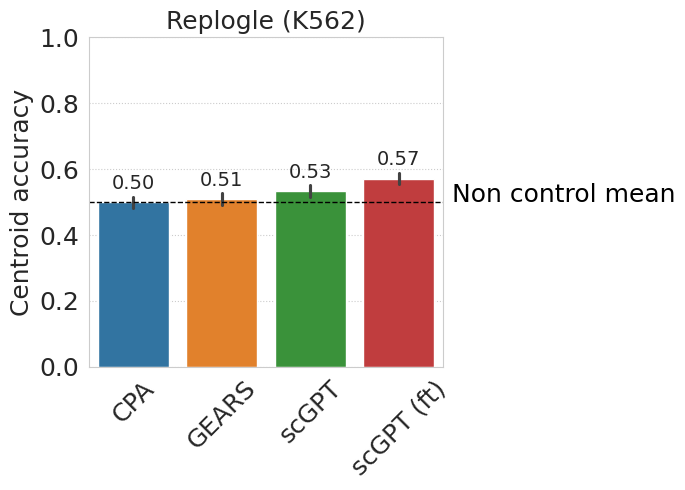

In [1079]:
sns.set_style('whitegrid')
fontsize = 18
df = pairwise_scores_df.melt(var_name='method', value_name='value')
nonctl_mean_acc =  df[df['method'] == 'nonctl-mean']['value'].mean()
df_ = df[df['method'] != 'nonctl-mean']

plt.figure(figsize=(7, 5))
ax = sns.barplot(df_, x='method', y='value', hue='method')
# **Add numerical labels on bars**
for bar, std_err in zip(ax.patches, std_error.values.ravel()):
    height = bar.get_height()
    # f'{height:.2f}$\pm${std_err:.2f}'
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.04, 
            f'{height:.2f}', ha='center', fontsize=fontsize-4)

plt.axhline(y=nonctl_mean_acc, linewidth=1, color='k', linestyle='dashed')
plt.text(3.6, nonctl_mean_acc + 0., 'Non control mean', color='black', fontsize=fontsize)
plt.grid(linestyle='dotted', axis='y')
plt.xlabel('')
plt.ylabel('Centroid accuracy', fontsize=fontsize)
plt.title('Replogle (K562)', fontsize=fontsize)
labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)']
plt.yticks(fontsize=fontsize)
plt.xticks(np.arange(4), labels, fontsize=fontsize, rotation=45);
plt.ylim((0, 1))
plt.tight_layout()
plt.savefig(f'{figdir}/{dataset}_centroid_accuracy.pdf', bbox_inches='tight');
plt.show()

In [1191]:
for c in adata.obs['condition'].unique():
    split = c.split('+')
    if len(split) > 1:
        assert split[1] == 'ctrl'

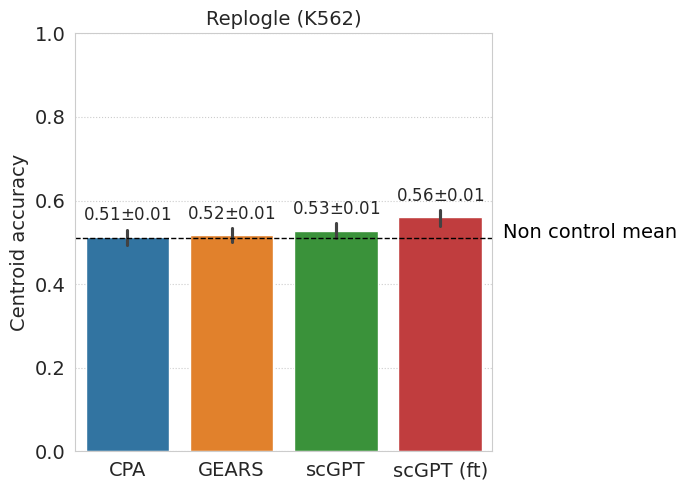

In [1057]:
sns.set_style('whitegrid')
fontsize = 18
pairwise_scores_df_ = pairwise_scores_df.loc[~pairwise_scores_df.index.str.startswith('RP')]
pairwise_scores_df_ = pairwise_scores_df_.loc[[g for g in pairwise_scores_df_.index if g not in lead_genes]]
df = pairwise_scores_df_.melt(var_name='method', value_name='value')
nonctl_mean_acc =  df[df['method'] == 'nonctl-mean']['value'].mean()
df_ = df[df['method'] != 'nonctl-mean']

plt.figure(figsize=(7, 5))
ax = sns.barplot(df_, x='method', y='value', hue='method')
# **Add numerical labels on bars**
for bar, std_err in zip(ax.patches, std_error.values.ravel()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.04, 
            f'{height:.2f}$\pm${std_err:.2f}', ha='center', fontsize=fontsize-2)

plt.axhline(y=nonctl_mean_acc, linewidth=1, color='k', linestyle='dashed')
plt.text(3.6, nonctl_mean_acc + 0., 'Non control mean', color='black', fontsize=fontsize)
plt.grid(linestyle='dotted', axis='y')
plt.xlabel('')
plt.ylabel('Centroid accuracy', fontsize=fontsize)
plt.title('Replogle (K562)', fontsize=fontsize)
labels=['CPA', 'GEARS', 'scGPT', 'scGPT (ft)']
plt.yticks(fontsize=fontsize)
plt.xticks(np.arange(4), labels, fontsize=fontsize);
plt.ylim((0, 1))
plt.tight_layout()
# plt.savefig(f'{figdir}/{dataset}_centroid_accuracy_noRPgenes.pdf', bbox_inches='tight');
plt.show()

In [1005]:
means = df_.groupby('method').mean()
stds = df_.groupby('method').std()
ns = df_.groupby('method').count()
std_error = stds / np.sqrt(ns)
means, std_error, ns

(             value
 method            
 cpa       0.499198
 gears     0.508727
 scgpt     0.533652
 scgpt_ft  0.571513,
              value
 method            
 cpa       0.008879
 gears     0.008933
 scgpt     0.009282
 scgpt_ft  0.009399,
           value
 method         
 cpa        1043
 gears      1043
 scgpt      1043
 scgpt_ft   1043)

In [477]:
closest_perts_df = dist_df.idxmin(axis=1)
closest_perts_df.xs('scgpt_ft', level=1)

condition  seed
DHX15      1       SEC61A1
SLIRP      1       SEC61A1
SDE2       1       SEC61A1
RPL31      1        FERMT2
PDPK1      1       SEC61A1
                    ...   
SRSF11     2         MIS12
RPL21      2         RPL21
VPS35      2         UBAP1
ING5       2         UBAP1
PARN       2         UBAP1
Length: 908, dtype: object

In [486]:
cin_k562_df['gene_id'] = cin_k562_df.index.str.split('_').str[-1]
zscores_k562 = cin_k562_df[cin_k562_df['gene_id'].isin(adata.obs['gene_id'].unique())].groupby('gene_id')[['Z-scored CIN score']].mean()
df = adata.var[['gene_name']].copy()
df.loc['non-targeting'] = 'control'
zscores_k562['gene_name'] = df.loc[zscores_k562.index]
zscores_k562 = zscores_k562.set_index('gene_name')

method_closest_df = closest_perts_df.xs('scgpt_ft', level=1)
x = zscores_k562.loc[method_closest_df.index.get_level_values(0)]
y = zscores_k562.loc[method_closest_df.values]

array([[1.        , 0.12661931],
       [0.12661931, 1.        ]])

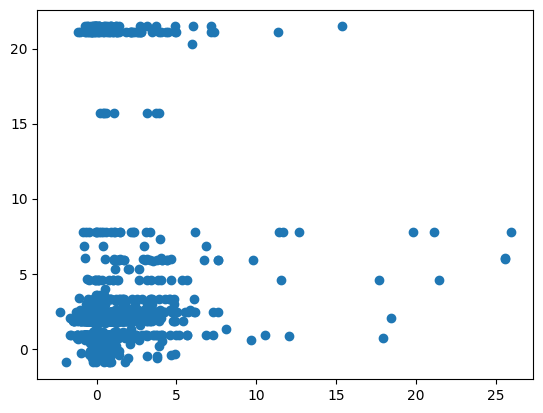

In [494]:
plt.scatter(x, y)
np.corrcoef(x.values[:, 0], y.values[:, 0])

In [484]:
dist_df.index.get_level_values(0)

Index(['POP5', 'RPL19', 'SLC35B2', 'TBCB', 'RAD51C', 'DAP3', 'BRD8', 'RPS5',
       'RRP36', 'DENR',
       ...
       'WDR74', 'DCPS', 'RPL6', 'TASOR2', 'STX18', 'EIF5', 'AKIRIN2',
       'SLC35F6', 'SLC39A9', 'PDCD11'],
      dtype='object', name='condition', length=5448)